In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # NOTE: imblearn Pipeline (not sklearn)

# Dataset
import kagglehub
from kagglehub import KaggleDatasetAdapter


In [12]:
# Downloading the latest version of the dataset
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")

print("Path to dataset files:", path)


Path to dataset files: /Users/carson_nov_2025/.cache/kagglehub/datasets/maharshipandya/-spotify-tracks-dataset/versions/1


In [13]:
df = pd.read_csv(path + '/dataset.csv')
df = df.drop(df.columns[0], axis=1)
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


# Data Processing

We want to be able to include features like 'explicit', 'mode', 'key', 'time_signature', 'track_genre', 'artists', but these are binary and categorical features (binary: explicit, mode ; the rest are categorical)

We will use a similar method / reasoning to the linear regression data processing for random-forest.


In [33]:
numeric_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'loudness', 
    'mode', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo'
]

categorical_features = [
    'key', 'time_signature'
]

categorical_features_xl = [
    'track_genre', 'artists'
] # optionally add 'artists'

features = numeric_features + categorical_features + categorical_features_xl
target = 'popularity'

In [34]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

categorical_transformer_xl = Pipeline(
    steps=[
        ("target", TargetEncoder(smooth=5.0))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("cat_xl", categorical_transformer_xl, categorical_features_xl)
    ]
)

In [35]:
rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(
            n_estimators=300,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

In [36]:
X = df[features]
y = df[target]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
# this took me 7 min to run
rf_pipeline.fit(X_train, y_train)


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration_ms', 'explicit',
                                                   'danceability', 'energy',
                                                   'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['key', 'time_signature']),
                                                 ('cat_xl',
                                                  Pipeline(steps=[('target',
                                                                   TargetEncoder(smooth=5.0))]),
                                                  ['track_genre',
                                                   'artists'])])),
                ('model',
                 RandomForestRegressor(n_estimators=300, n_jobs=-1,
                                       random_state=42))])

In [25]:
y_pred = rf_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

NotFittedError: Pipeline is not fitted yet.

Classification Report:
              precision    recall  f1-score   support

    Negative       0.96      0.93      0.95     19836
    Positive       0.62      0.76      0.69      2964

    accuracy                           0.91     22800
   macro avg       0.79      0.85      0.82     22800
weighted avg       0.92      0.91      0.91     22800



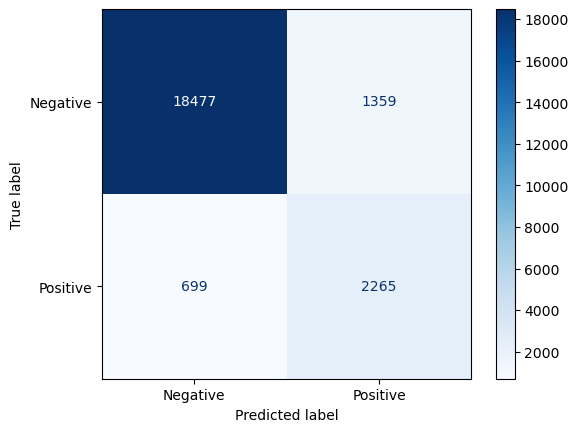


****************************************************************************************************

Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.89      0.87     10097
    Positive       0.91      0.87      0.89     12703

    accuracy                           0.88     22800
   macro avg       0.88      0.88      0.88     22800
weighted avg       0.88      0.88      0.88     22800



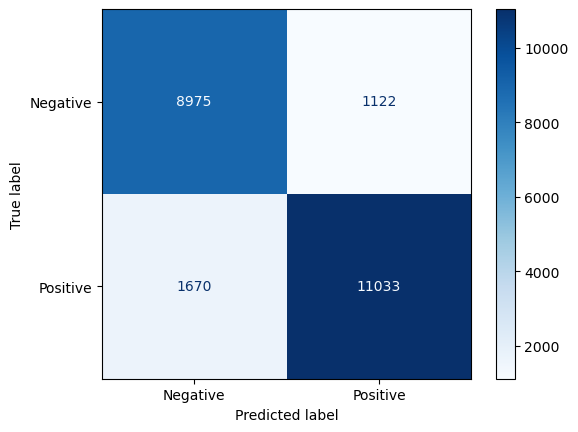

Using a popularity as 30 for cutoff between popular and not popular

              precision    recall  f1-score   support

    Negative       0.86      0.83      0.84     10121
    Positive       0.87      0.89      0.88     12679

    accuracy                           0.86     22800
   macro avg       0.86      0.86      0.86     22800
weighted avg       0.86      0.86      0.86     22800



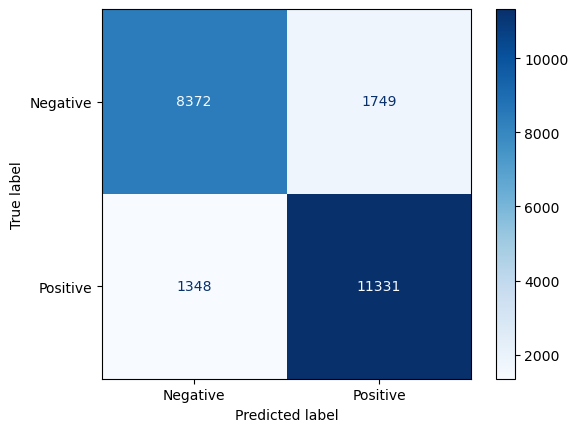

In [38]:
# Turn continuous data into classification data

rfc_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('regressor', RandomForestClassifier())
])

X_class = df[numeric_features + categorical_features + categorical_features_xl]
y_class = (df["popularity"] >= 60).astype(int)

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42, stratify=y_class)

rfc_model.fit(X_train_class, y_train_class)

# Predict
y_pred_class = rfc_model.predict(X_test_class)

report = classification_report(y_test_class, y_pred_class, target_names=['Negative', 'Positive'])
print("Classification Report:")
print(report)


res = confusion_matrix(y_test_class, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=res, display_labels=["Negative", "Positive"])

disp.plot(cmap=plt.cm.Blues)
plt.show()

print()
print("*" * 100)
print()

X_class = df[numeric_features + categorical_features + categorical_features_xl]
y_class = (df["popularity"] >= 30).astype(int)

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42, stratify=y_class)

rfc_model.fit(X_train_class, y_train_class)

# Predict
y_pred_class = rfc_model.predict(X_test_class)

report = classification_report(y_test_class, y_pred_class, target_names=['Negative', 'Positive'])
print("Classification Report:")
print(report)


res = confusion_matrix(y_test_class, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=res, display_labels=["Negative", "Positive"])

disp.plot(cmap=plt.cm.Blues)
plt.show()

print("Using a popularity as 30 for cutoff between popular and not popular\n")
y_pred_class = np.ones_like(y_pred)
y_test_class = np.ones_like(y_test)

y_pred_class[y_pred < 30] = 0
y_test_class[y_test < 30] = 0

report = classification_report(y_test_class, y_pred_class, target_names=['Negative', 'Positive'])
print(report)

res = confusion_matrix(y_test_class, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=res, display_labels=["Negative", "Positive"])

disp.plot(cmap=plt.cm.Blues)
plt.show()

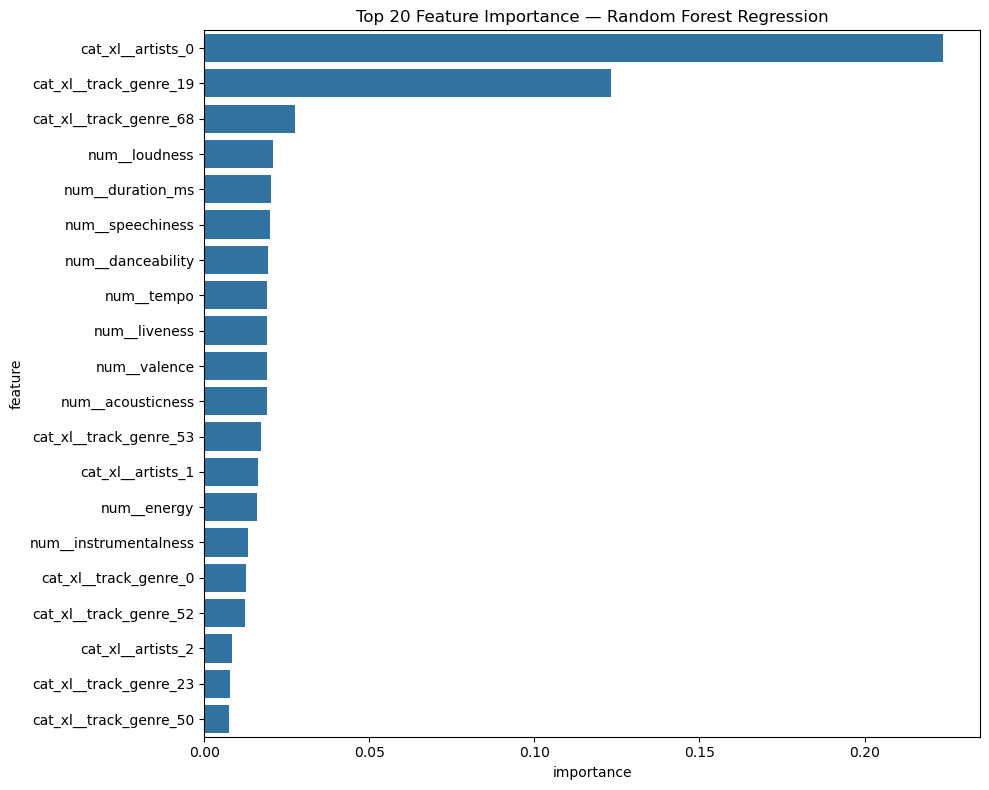

In [49]:
# Extract feature importances from model inside pipeline
preprocessor = rf_pipeline.named_steps["preprocessor"]
model = rf_pipeline.named_steps["model"]

feature_names = preprocessor.get_feature_names_out()
importances = model.feature_importances_

feat_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x="importance", y="feature", data=feat_importances.head(20))
plt.title("Top 20 Feature Importance — Random Forest Regression")
plt.tight_layout()
plt.show()


In [50]:
feat_importances

,feature,importance
130,cat_xl__artists_0,0.223785
48,cat_xl__track_genre_19,0.123107
97,cat_xl__track_genre_68,0.027622
4,num__loudness,0.020880
0,num__duration_ms,0.020274
...,...,...
221,cat_xl__artists_91,0.000263
225,cat_xl__artists_95,0.000214
224,cat_xl__artists_94,0.000200
25,cat__time_signature_1,0.000167


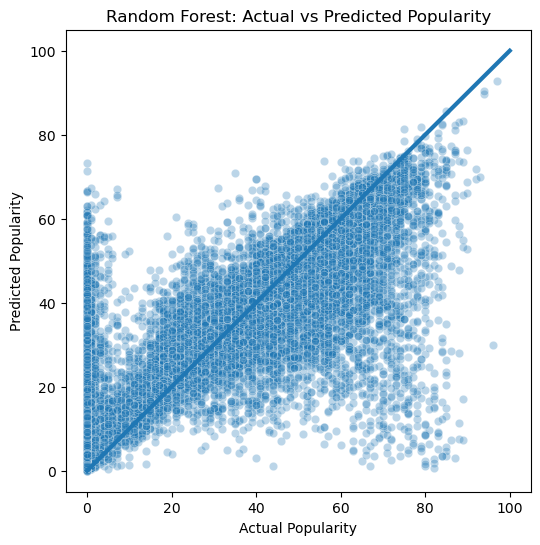

In [51]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([0,100],[0,100], linewidth=3)  # diagonal line
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title("Random Forest: Actual vs Predicted Popularity")
plt.show()
